<a href="https://colab.research.google.com/github/yvrjsharma/Keras-edition-deux/blob/main/Keras_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Deep Learning for Computer Vision

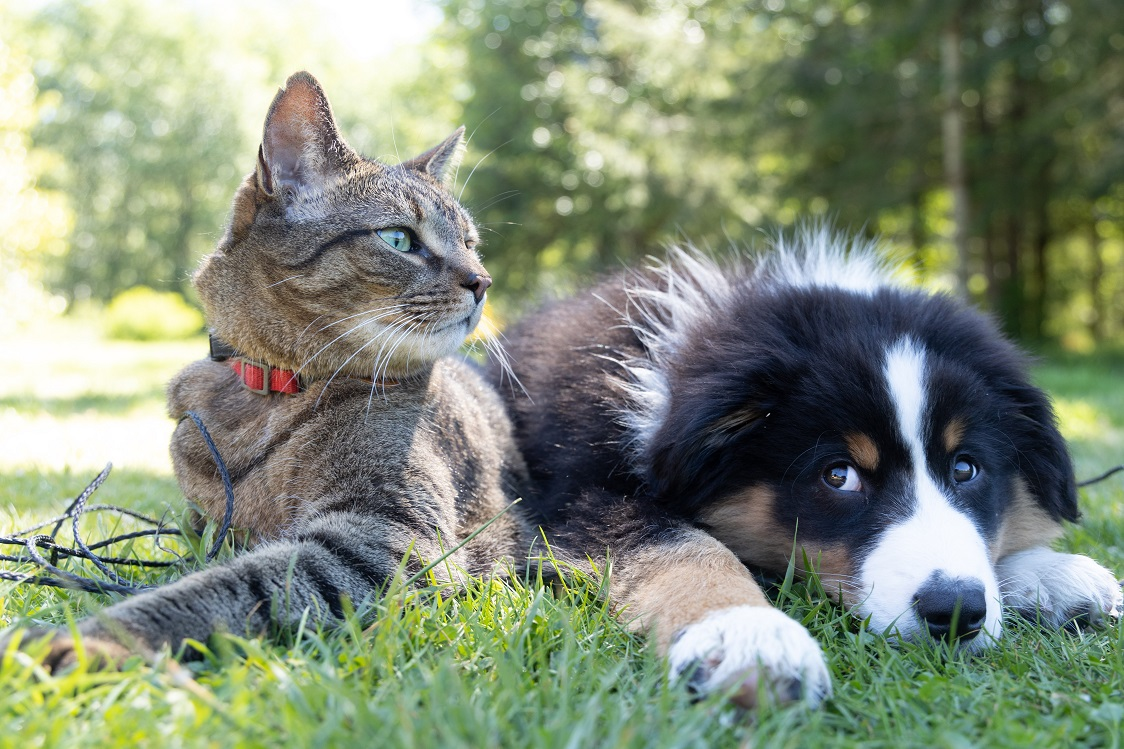

Photo by <a href="https://unsplash.com/@sita2?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Andrew S</a> on <a href="https://unsplash.com/s/photos/cats-and-dogs?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

With the rise of *Convolutional Networks* after 2012, Computer Vision has seen a rapid adoption of Deeplearning techniques in every problem domain - Image classification, segmentation, OCR, self-driving and so on. This post and chapter explains convolutional networks or *convnets* and how you can use them in image classification problems.

Lets start by implementing image classification on our previously used MNIST dataset using the Functional API we discussed in last post.
* Convnets are basically a stack of *Conv2D* and *MaxPooling2D* layers.
* As an input it should be a tensor of shape ```(image_height, image_width, image_channels)```. Channels would mean how many spectrums of light are there in the image, for example a regular colored or RGB image would have 3 channels, while a multi-spectral satelite image can have 3 RGB channels plus UV, Infrared and many more.


In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
#A convolutional network
inputs = keras.Input(shape=(28,28,1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, "softmax")(x)
model = keras.Model(inputs, outputs)

#Displaying the architecture of this conv net
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

Let's observe the above ntwork -
* Output of every conv and maxpool layer is a 3D tensor
* The height and width dimensions shrink in size as we go deeper in the network
* Last layer sia densely connected softmax classifier just like we been coding till now
* This dense layer expects a 1D input not a 3D tensor, thus we hve used a Flattening layer to flatten the 3D output to a 1D input. 

Let's train on MINST data now. You will need loss as categorical crossentropy, but since labels are all integers we woyuld use sparse categorical crossentropy. You will notice the test accyracy comes up more than 99% where as in case of densely connected netweorks it was around 97.8%. This is a good improvement of percentage points.

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
#no. of samples, height, width, channels
train_images = train_images.reshape(60000, 28,28,1).astype('float32')/255
test_images = test_images.reshape(10000, 28,28,1).astype('float32')/255

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
 
model.fit(train_images, train_labels, epochs=5,batch_size=64)

#Evaluating as well
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"test accuracy: {test_accuracy:.3f}")

Epoch 1/5
938/938 [==============================] - 14s 4ms/step - loss: 0.1532 - accuracy: 0.9521
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0414 - accuracy: 0.9869
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0288 - accuracy: 0.9910
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0225 - accuracy: 0.9934
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0279 - accuracy: 0.9905
test accuracy: 0.990


## Convolution Operation

Lets dive deeper and understand how the above network worked exactly. 

* Unlike Dense layers which learn global patterns insiode the input image, a convolutional network learns local patterns. these local patterns can be corners, straight libnes, curves, shapes and so on.

* Another way to put convnet's learning process is that it is **translational-invariant**. This means that if a convnet learns a pattern in one 3*3 pixel metric of an image, it reuses this representation to interpret the similar pattern occuring anywhere in the image after that. Dense layers have to learn a feature everytime it apprears in an image. This makes a convnet more data efficient. A convnet would thus need smaller number of images to train on to give good results.

* Also note that a convnet **learns spatial hierarchy of patterns**. This would mean that every consecutive layer, input onwards, learns more and more complex patterns from the image. For example, first few layers might learn about lines and corners, next few layers may learn about shapes, and still next few layers might start recognizing faces, cars, tyres *etc.* from an image and so on.

* In this example you saw that convnets learn in *rank-3 tensors*. These tensors are also called **feature-maps**. Two spatial axes or first two dimensions are for height and width of image while the last or third one is for *depth* or the *channels*. RGB image would have depth or channels as 3, while a greyscale image like mnist will have 1 channel only (as shown in above code).

* Every conv layer is producing an *output feature map* with height, width and an arbitrary number of channels or depth. These channels are also called **filters**. Understanding is that these filters encode specific aspects of the input data, for example, one filter might encode a face of a cat or a dog.

* Every convolution operation can be expressed using two variables:
  * Size of the pathches been extracted from the input image -- In the given example above, size of a patch is 3*3 or a 3 cross 3 pixel metric.
  * Depth of feature map - for example, 32 channels or filters that are copmputed in the first convolution operation.
* A convolution works by sliding a 3*3 size window (dimension depends on kernel suize) over the imnput image or the input feature map (for *inner* layers) and extracting at every stop a 3D patch of surrounding features (with shape as ```( window_height, window_height, input_depth)```). Each of these 3D patches is transformed into a 1D vector of shape (output_depth,) using a *convolution kernel*. All these 1D vectors are then  reassemnbled into a 3D output map of shape (height, width, output_depth) spatially. Every spatial location in this output feature map resembles the convolution over same spatial location in the input spatial feature map.

* **Padding**
  * If yuo want to include every input pixel into your convolution operation, you have add a *padding* on the sides of the image. 
  * The manner in which convolution happens by sliding a 3*3 or 5*5 window over the inout image, the resulting images gets shorter in the size. 
  * Padding argument in Conv2D layer has default value as "valid" which means no padding or we can choose to pass value as "same", wwhich would mean the layer will make sure to include padding in the input appropriately to keep the size (height, width) of output image as same.  

* **Strides**
  * Stride refers to the pixel distance travelled by the sliding window while calculating two consecutive convolutions.
  * The Conv2D layer take Stride as an agrgument and its default value is 1.
  * Stride can also decrease the size of an input image considerably for higher stride values.

* **Max-Pooling**
 * Reduces size of input feature map (height, wwidth) aggressively.
 * Max Pooling is usually done with 2*2 windows and stride 2, to downsample the feature maps by a factor of 2 (halving it every time).
 * If you remove the max pooling layers from your convnet , you might run into a few problems like -
    * The number of parameters will be very high. On a small dataset like MNIST, that can lead to overfitting. It will also lead to higher computing time and resources.
    * Secondly, this isn't conducive to learning spatial hierarchy of features. Successive conv layers will not be able to look at important features from precedding layers. The netwrok will thus not be able to learn high-level pattterns.
  * We can also use **Average Pooling**, where every 2\*2 window is replaced by the average of the pixel values instead of the max value. however, *max pooling performs better*.
  * Best performing satrategy is to use unstrided conv layers (giving gives denser map of features) followed by max pooling layers which will extract maximal features over small patches or windows.

## Approaching a problem of Computer Vision using Convnets

* Small dataset of cats and dogs - 2500 images of each. We will divide the data into train-2000, validation-1000, and testing-2000 images sets.
* **Start by setting a baseline** -- We will train a small convnet without regularization and let the model overfit.
* Next, we will introduce **Data Augmentation**, one of the main tool to reduce overfitting in CV problems.
* Later we will perform **transfer learning** using a pretrained classifier by doing -
  * Feature extraction, and
  * Fine Tuning

*Feature reuse* is one of the keay features of deep learmining models. A model trainded over large ImageNet dataset can be used to bootstratp classification solutions for problems involving *small* image datasets by *simply* using it and plugging it in with minor changes.

Lets start solving this Cat and Dog classification problem -

a. **Downloading the Data** 

In [6]:
#To download the data from Kaggle website - www.kaggle.com using kaggle API 

#goto to kaggle.com -> my account -> API section -> create nw API
#upload json file with your API token
from google.colab import files
files.upload()
#creating a folder and moving this json file to it
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#lets download the data
!kaggle competitions download -c dogs-vs-cats

#unzipping the trainning data
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
 97% 263M/271M [00:01<00:00, 174MB/s]
100% 271M/271M [00:01<00:00, 171MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 92.4MB/s]
 96% 522M/543M [00:02<00:00, 240MB/s]
100% 543M/543M [00:02<00:00, 213MB/s]


In [7]:
#the dataset size is 25000 images, lets subsample it 
#creating smaller dataset with train, val, test as 2000,1000, 2000 images eachs respectively
#keeping equal proportion of cats and dogs images in all three sets
import os, shutil, pathlib
#dir where we uncompressed the data
original_dir = pathlib.Path("train")
#new dir to store the subset
new_base_dir = pathlib.Path("cats_vs_dogs_small")

#creating subfolders a train, val and test and moving images in them in cats and dogs directories
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

b. **Building the Model**
* Building a stack of alternate Conv2D layers with Relu activation and MaxPooling2D layers
* Images are bigger than mnist, thus we would need a bigger model -- more conv layers followed by maxpool8ing layers
* We will start with a 180\*180 pixel image and would reduce it to 7\*7 as the Flatten layer input. Depth of feature maps will increase progressively from input to output.
* Binary classification between a cat and a dog image category - thus we will have sigmoid as the final dense conected layer.
* We will rescale the input pixel values, which are between 0 to 255, to values between 0 and 1.  

In [4]:
#this line would mean that model will expect RGB 3 channel images or colored images as input with 180*180 pixel in size
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180,180,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [5]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=["accuracy"])

c. **Data preprocessing**

* Input data needs to be floating point tensors of a specific shape as input described above.
* Data is in jpeg format right now, we need to perform follwoig steps to make it usable for the model --
    * Read the image files from the locations
    * Convert jpeg images to rgb grids of pixels
    * Convert pixel values to float tensors
    * Resize input to 180\*180 pixel
    * Create batches of input images to be processed
* We will be using one of the most amazing keras utility ```image_dataset_from _directory()``` to perform all these operations. This function creates a data pipleline for yo to perform all operations listed above in a simple and efficient manner. 
* This function will return a ```tf.data.dataset``` object. This objct allows you to do all the required operations :
    * Read image files
    * shuffle the files
    * decode them to tensors
    * resize the images
    * create batches

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(180,180), batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation", image_size=(180,180), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(180,180), batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


    More about tf.data.Dataset objects -
    * Tensorflow offers this API called tf.data which allows users to create input pipelines for their models
    * A Dataset obhect is an iterator, so it can be used in a *for* loop easily
    * A Dataset object can be passed in to the model.fit() fucntion
    * It returns batches of data and labels

    Lets look at the below code example to understand how the Dataset object acts as an iterator and what values it returns -

In [7]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


d. **Model Training and Checkpointing**
* ModelCheckpoint callback can be used to save the model weights after every epoch during training. 
* This way we dont have to retrain a new model after model starts overfitting. We can simply use the saved model weights from last stable epoch.
* In below example code, ```save_best_only=True, monitor="val_loss"``` tells the callback to only save a new model weight file if the new validation loss is lower than any previous time during the traininig.

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=callbacks)

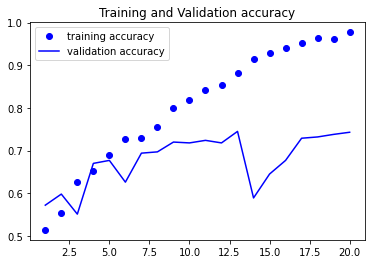

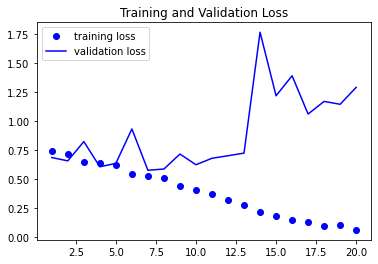

In [10]:
#plotting the loss of this new model
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs= range(1,len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In above model training, we notice that the Validation loss stops decreasing around tenth epoch. Next we will reload the model from model checkpoint weights saved, and would observe the performance over the test sets. This comes around 67.8%. When you run it you might get a slight bit different number this time around, this is because of the randomness of weight initialization in neural networks.


In [11]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuray : {test_acc:.3f}")

63/63 [==============================] - 2s 24ms/step - loss: 0.6133 - accuracy: 0.6775
Test Accuray : 0.678


* Such low accuracy is because we have so few images in our training dataset (only 2000). This has led to high overfitting. A new way to deal with overfitting is called **Data Augmentation**.
* Data Augmentation helps in inccreasing the traiininig data when you have too few samples to traiin on.
* Data Augmentation uses exisiting images to generate new ones using a number of random transformations that yield believable looking images. This helps expose the model to more aspects of data at the training time.
* Keras handle image data augmentation by adding a number of data augmentation layers at the start of your model.

Lets look at the code and some sample images under going augmentation -

In [12]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),  #applies horizontal flip to 50% images on random
                                      layers.RandomRotation(0.1), #rotates the image 10% on either side.
                                      layers.RandomZoom(0.2)])  #zooms in or out images by random factor between -20% to 20%

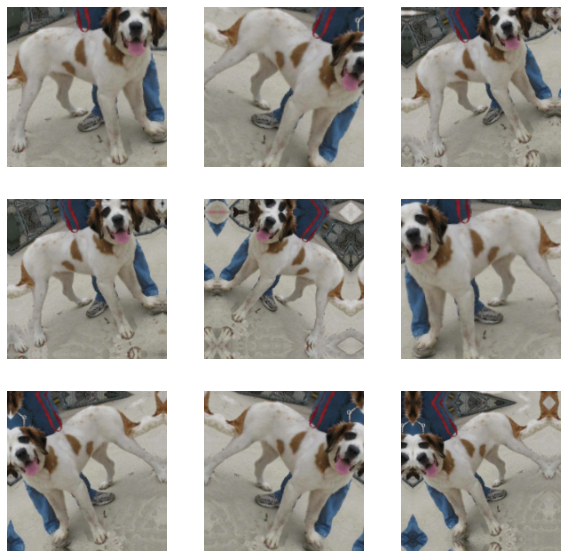

In [13]:
plt.figure(figsize=(10,10))
#take(n) helps you get the n batches at one go
for images, _ in train_dataset.take(1):
  for i in range(9):
    #apply augmentation to the image batch extracted 
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    #displaying the first image only
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

* Using this data augmentation approach, the number of trainnng images has increased. The model might never see the same image twice. However, the images are still intercorrelated as they are derived from same set of images. Thus, **augmentation reduces overfitting** but only to an extent.

* Another way to avoid overfittig is to use **Dropout layers** just before the last dense connected classifier layer (*sigmoid*).

* Both for data augmentation layers and dropout layers, they are active during training and inactive duing inferennce (evaluate() and predict() calls). This would mean that the *model will behave as if these layers does not exist at the time of evaluation.*

Lets rebuild the model with augmentationa and dropout an train it too --


In [26]:
#new model
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

#Compiling the model
model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=["accuracy"])

In [27]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch_with_augmentation.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks, verbose=0)

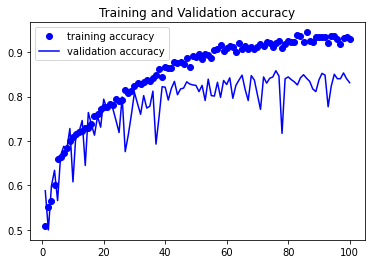

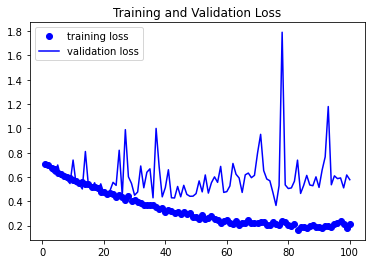

In [16]:
#plotting the loss of this new model
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs= range(1,len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

Lets calcuulate the performnce over the test set again and observe the test set accuracy this time. We get considerable increase since last time's 68% to 84% --


In [17]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuray : {test_acc:.3f}")

63/63 [==============================] - 1s 19ms/step - loss: 0.5028 - accuracy: 0.8360
Test Accuray : 0.836


## Leveraging Pretrained models

* Since we had so little data to start with (just 2000 train set images), even by augmenting the data we are only able to increase the test/validation accuracy to 84%, or may be till 90% if we go on tweaking the hyperparameters. We need a newer approach to go from here.
* In deep learning an effective approach to increase accuracy is to use pretrained models. A **Pretrained Model** is a model which is previously trained on a large dataset, typically for a large-scale classification task.
* If this original dataset was general and large enough, the spatial hierarchy learned by deep learning model can effectively act as a generic view of the world. These learned features can be used to classify newer data even for previously unseen set of classes.
* Such portability of learned features across different problems is a key feature of deep learninig algorithms.
* Here we will be using a large convenet trained on ImageNet dataset of over 1.4 million labeled imagees belonging to 1000 different classes. This model is called the **VGG16** architecture.
* There are two ways to use pretrained model or to do transfer laerning - Feature Extraction and Fine Tuning. Lets learn about them in detail -

### Feature Extraction

* Observe the model architecture that we used in our last model - It has a series of conv and maxpooling layers that constitute the *convolutional base* of mode. This is followed by the densely connected classifier layer.
* In Feature Extraction, this conv base of a previously trained model (VGG16 in our case) is first run through the new data of our cats and dogs (training data availabel to us). Second, we train a new classifier on top of the output.
* Idea is that the feature maps of a convnet are presence maps of generic concepts over a picture, which are likely to be useful regardless of the computer vision problem at hand.
* The level of genrality and reusability of the representations extracted by specific conv layer depends on the depth of the layer in the model. You have to make the call on using entire convilutional base or fewer layers inside of it. The intial few layers would etxrract local, highly generic feature maps like colors, edges, textures *etc*. Later layers start extracting more complex or problem specifc featires like dog's ears, cat's eyes and so on. If your clasification problem differs aot from what the Petrained model was trained on, you should go for intial few layers rather than using the full conv base and vice versa.

In following code we will perform Feature Extraction using VGG16 from keras.applications modeule.

      keras.applications module has many other image-classifcations models, and they are all pretrainded on the same ImageNet dataset:
      Xception
      Resnet
      MobileNet
      EfficientNet
      DenseNet etc.




In [39]:
from tensorflow import keras
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(180,180,3))

* *weights* means the checkpoint weights with which we want to intialize our model
* *include_top* would mean the choice of including the densely connected classifier on the top. This would mean 1000 classes by default.
* *input_shape* indiactes the shape of image tensors coming in as input to this network. This is optional to specify. Ntwork can figure out on its own as well. 

Lets look at the architecture of this convlutional nbase network -

In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Kindly note the final feature map has shape (5,5,512), we will be connecting our dense classifictaion layer for binary classifictaion between cats and dogs. 

Two possible approaches to perform classification using Feature Extraction now -

* Approach 1
  1. Run the conv_base over our dataset (only once),
  2. Record this outut to a Numpy array on disk,
  3. use this data as input to a new densely connected classifier
  * This approach is fast and cheap. We are running the large VGG16 conv base only once over our data. We can't use augmented data here.
  * We can extract the features using conv_base.predict() method.

* Approach 2
  1. Extend the conv_base bby adding dense layers on top
  2. Run the whole new network from end to end on our train data. 
  * We can use data augmentation but then it will become too expensive to train such a large network.


Lets's first look at the **Approach 1 for Feature Extraction** in details below :

In [40]:
#Approach 1 - extracting features as numpy arrays
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    #vgg16 expects preprocessed images
    #this method scales the pixel values to an apt range as well
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    #predict() expects onyly images and not labels
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [41]:
#Displaying the shape of extracted features:
train_features.shape

(2000, 5, 5, 512)

In [ ]:
#Finally creating a dense classifier using these extracted features:

inputs = keras.Input(shape=(5,5,512))
#need to flat the input for dense layers
x = layers.Flatten()(inputs) 
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, "sigmoid")(x)
model = keras.Model(inputs, outputs)

#compile
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

#training and model checkpointing
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=callbacks)

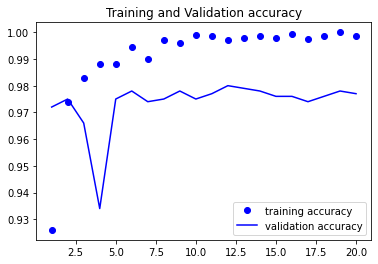

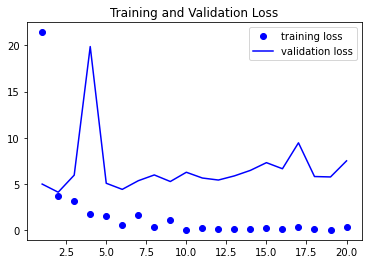

In [36]:
#plotting the loss of this new model
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs= range(1,len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [38]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test Accuray : {test_acc:.3f}")

63/63 [==============================] - 0s 3ms/step - loss: 5.4718 - accuracy: 0.9660
Test Accuray : 0.966


* This time aroudn we have obtained the test set accuracy of 96%, which is way higher from when we first started.
* However, we are still overfititng, if you look at the plots for loss. This is because of small dataset we are using. Data augmentation can solve this problem but we were unable to use it in this approach. Lets look at *Approach 2* for problem to this solution of ovrfitting -- 

**Approach 2 : Feature Extraction together with Data Augmentation**

* Slower and more expensive than Approach 1 discussed above
* We will augment the data to counter overfitting
* We need to freeze weights in conv_base as well - meaning these weights will not get updated during the training. We dont want the previously learned weights in vgg16 to be updated during training as the new task is very close to the original task of ImageNet classification.
* Then we will chain the data augentation layer with *conv_base* netwrok and then with a new dense classifier and train it end to end on augmented dataset. 


In [46]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(180,180,3))

#printing weights before and after freezing
print("This is total number of training weights before Freezing : ", len(conv_base.trainable_weights))

#To freeze trainning on this whole base
conv_base.trainable = False

print("This is total number of training weights AFTER Freezing : ", len(conv_base.trainable_weights))

This is total number of training weights before Freezing :  26
This is total number of training weights AFTER Freezing :  0


In [ ]:
#Approach 2: New network chained together

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#training and model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

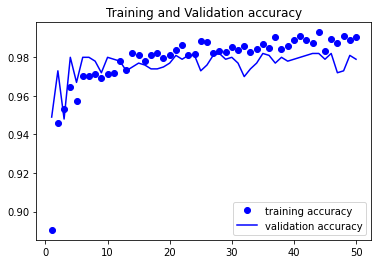

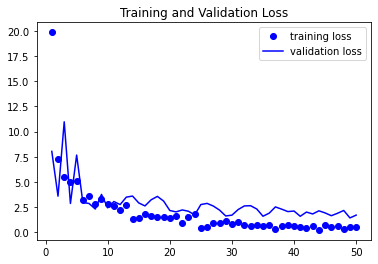

In [51]:
#plotting the loss of this new model
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs= range(1,len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

* As you can see the Validation accuracy is around 98% which is very high in comparison to all previous model approaches.

* Test accuracy is coming around 98% -- 

In [54]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuray : {test_acc:.3f}")

63/63 [==============================] - 3s 49ms/step - loss: 1.9662 - accuracy: 0.9760
Test Accuray : 0.976


### Fine-Tuning a Pre-trained model

* Unfreezing a few of the top layers of a frozen model base (eg, *conv_base*) and jointly training both the newly added part of the model (eg, a set of dense classifier layers) and these top layers.
* It is called *fine-tuning* because we slightly adjust the weights in pretrained model's top layers to make them more rlevant for the classification task at hand.
* Note that, it is only possible to fine-tune the top layers in a pretrained model, once the additional classifier is already been traiined. Else the error singal propagating through the network will be too large and all the information (weights) prelearned in the top layers will likely get destroyed.
* Thus the Fine-tuning steps are -
  1. Add custom network on top of pretrained base network,
  2. Freeze  base network,
  3. Train the part we just added,
  4. unfreezesome top layers in base netwrok,
  5. Train again the top layers and the additioal network we added earlier. 

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(180,180,3))
#To freeze trainning on this whole base
conv_base.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


If you look at the summary for VGG16 below, you can understand it like this - we will be freezing weights in first 4 blocks (block1 to block4) and *fine-tuning* the bock5 layers along with the dense classifier we will add now.

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

* Earlier layers in VGG16 encode more generic reusable features like edges, textures *etc.* while last few layers encode problem specoifc feature maps. Thus it makes sense intuitively to train only the top layers or layers near the end.
* Sinec our problem dataset is small, the more parameters we train, the more we are at risk of over-fiting.
* We will add our dense classifier and would train uisng a *very low learining rate*, reason is that we dont want large magnitude of corrections to our wweights in the pretrained top layes. It will make sense to chip at them slowly and slowly, while showing more and more images to the model.
* You can observe that the Test accuracy is high - 97.4% using this aaproach.

In [4]:
#Freezing all layers till block5
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [ ]:
#Fine tuning : Reusing the model we created above in Approach 2 above

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

#training and model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

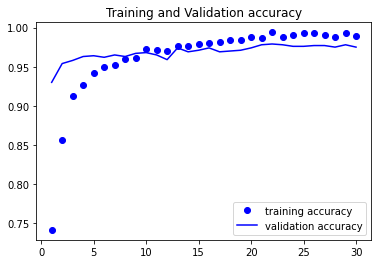

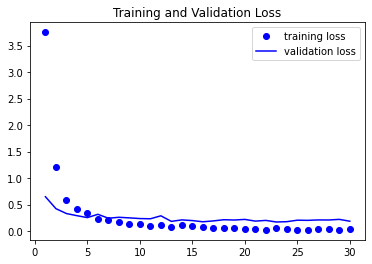

In [10]:
#plotting the loss of this new model
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs= range(1,len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [12]:
test_model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuray : {test_acc:.3f}")

63/63 [==============================] - 4s 52ms/step - loss: 0.1792 - accuracy: 0.9735
Test Accuray : 0.974


## Conclusion
* Convolutional Networks or Convnets perform really well even with small trainng data. 
* Convenets work by learning a hierarchy of patterns and visual concepts while training over a set of images.
* Overfitting is a serious issue in deep learning, especially if the dataset size is small. We learned about two cool new techniques in this chapter to counter effects of overfitting on small dataset - Data Augmentation and Dropouts.
* Pretrained image classification models can be used to do feature extraction to improve validation and test accuracy for small dataset problems.
* Fine-tuning helps by adapting top layers from a pretrained model to the new problem. This pushes the performance a bit higher as well.  